<a href="https://colab.research.google.com/github/MathMachado/DSWP/blob/master/Notebooks/NB10_04__3DP_4_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b><i>3DP_4 - ANOMALY/OUTLIER DETECTION</i></b></h1></center>



# **AGENDA**:

> Consulte a **Table of contents**.

# **Melhorias da sessão**
* Mostrar junto os gráficos com a região de Anomaly Score junto com a distribuição de probabilidade das variáveis envolvidas.
* Mensagens de deprecating --> Analisar e substituir os métodos, funções deprecated;


___
# **Referências**
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
* [Outlier detection with several methods](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html)
* [anomaly-detection-resources](https://github.com/MathMachado/anomaly-detection-resources)
* [Outlier Detection with Extended Isolation Forest](https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b)
* [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e).

___
## O que é Anomaly Detection (= Análise de Outliers)?
> Qualquer ponto/observação que é incomum quando comparado com todos os outros pontos/observações.

___
# **Machine Learning com Python (Scikit-Learn)**

![Scikit-Learn](https://github.com/MathMachado/Materials/blob/master/scikit-learn-1.png?raw=true)

___
# **Técnicas tradicionais para detecção de outliers**

## Boxplot
* $IQR = Q_{3}-Q_{1}$

![BoxPlot](https://github.com/MathMachado/Materials/blob/master/boxplot.png?raw=true)

## Z-Score
* Z-Score pode ser utilizado para detectar Outliers.
* É a diferença entre o valor e a média da amostra expressa como o número de desvios-padrão.
* Se o escore z for menor que 2,5 ou maior que 2,5, o valor estará nos 5% do menor ou maior valor (2,5% dos valores em ambas as extremidades da distribuição). No entanto, é pratica comum utilizarmos 3 ao invés dos 2,5.

![Z_Score](https://github.com/MathMachado/Materials/blob/master/Z_Score.png?raw=true)

___
# **Hands-On**

## Carrega as Bibliotecas necessárias

In [ ]:
!pip install pyod

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest

# Scaling variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

# remove warnings to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

## Carrega dataframe

In [48]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


In [49]:
df_titanic.isna().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [50]:
# Por simplicidade, vou descartando/omitindo todos os Missing Values
df_titanic = df_titanic.dropna() # Esta não é a forma adequada! Dê o devido tratamento aos Missing Values (NaN) da base de dados!
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True


In [51]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = StandardScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [52]:
# Linhas do df_titanic
df_titanic_ss.shape

(182, 15)

In [53]:
# Função para plotar o Boxplot
def boxplot_sobreviveu(df, column):
    plt.rcdefaults()
    sns.catplot(x = 'survived', y = column, kind = "box", data = df, height = 4, aspect = 1.5)

    # add data points to boxplot with stripplot
    sns.stripplot(x = 'survived', y = column, data = df, alpha = 0.3, jitter = 0.2, color = 'k');
    plt.show()

Esta é a visão univariada da variável 'fare':

In [54]:
df_titanic[['survived']].head()

,survived
1,1
3,1
6,0
10,1
11,1


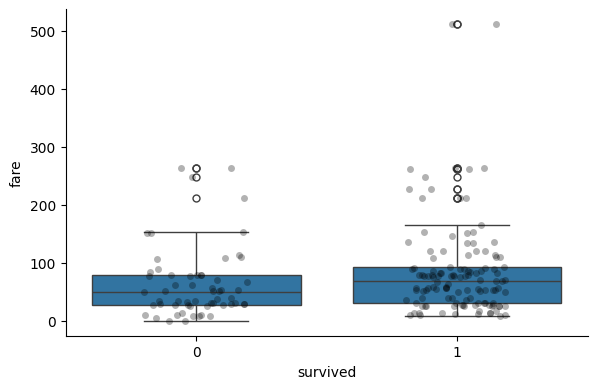

In [55]:
boxplot_sobreviveu(df_titanic, 'fare')

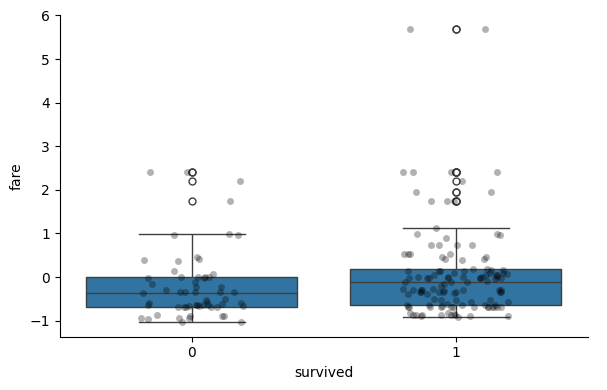

In [56]:
boxplot_sobreviveu(df_titanic_ss, 'fare')

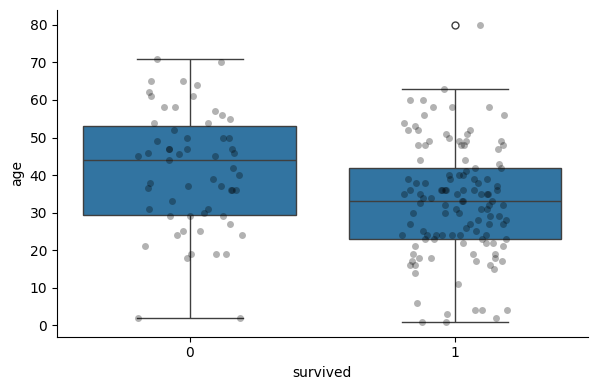

In [57]:
boxplot_sobreviveu(df_titanic, 'age')

In [58]:
# Descrever o dataframe, variável 'fare'
pd.set_option('display.float_format', lambda x: '%.3f' %x)
df_titanic_ss['fare'].describe()

,fare
count,182.000
mean,0.000
std,1.003
min,-1.035
25%,-0.645
50%,-0.287
75%,0.145
max,5.682


## Mostrar a frequência acumulada!! É mais informativo!!!

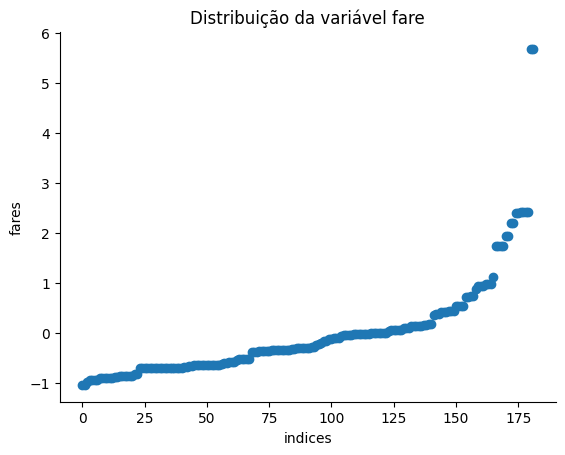

In [59]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['fare'].values)) # A intenção do gráfico é ordenar os valores em df_titanic['fare'] do menor valor para o maior!
plt.xlabel('indices')
plt.ylabel('fares')
plt.title("Distribuição da variável fare")

sns.despine()

Com o gráfico acima, podemos ver quais e quantos são os pontos que estão acima de $\mu + 3\sigma$ --> Se usarmos o critério do z-score, todos os pontos acima deste limiar são outliers!

 Colocar os gráficos lado a lado: df_titanic e df_titanic_ss!!

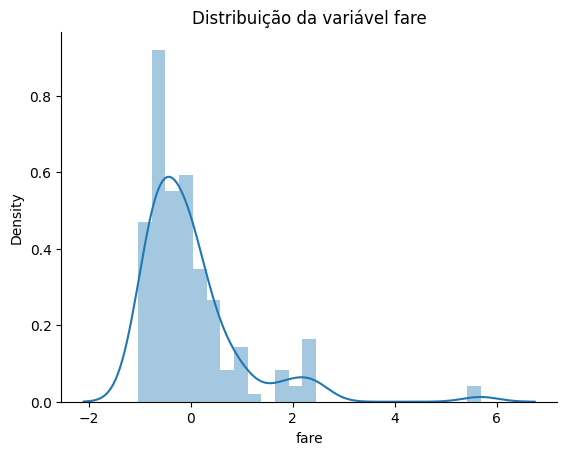

In [60]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic_ss['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

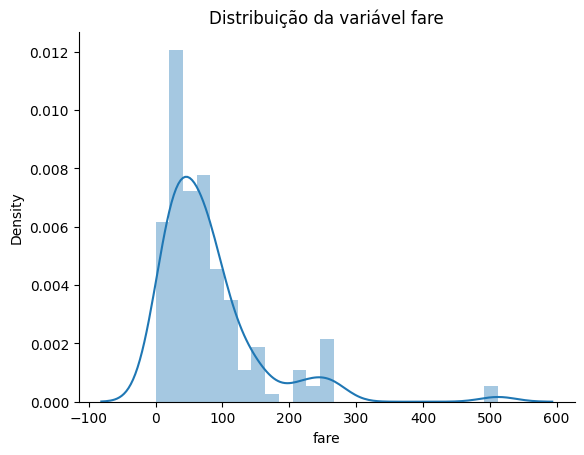

In [61]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

### Calcular a mediana e comparar com a média.

In [ ]:
df_titanic.describe()

___
## Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

___
## Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Materials/blob/master/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

### Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

> **Dica**: Normalize os dados antes!

In [62]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_titanic_ss['fare'].skew()}")
print(f"Kurtosis: {df_titanic_ss['fare'].kurt()}")

Skewness: 2.7073683146429004
Kurtosis: 10.690697893681472


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [63]:
# Distribuição da variável 'age'
df_titanic_ss['age'].describe()

,age
count,182.000
mean,0.000
std,1.003
min,-2.221
25%,-0.744
50%,0.024
75%,0.776
max,2.839


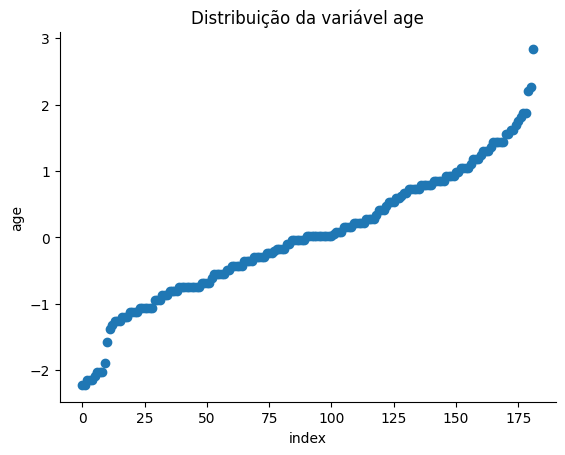

In [64]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

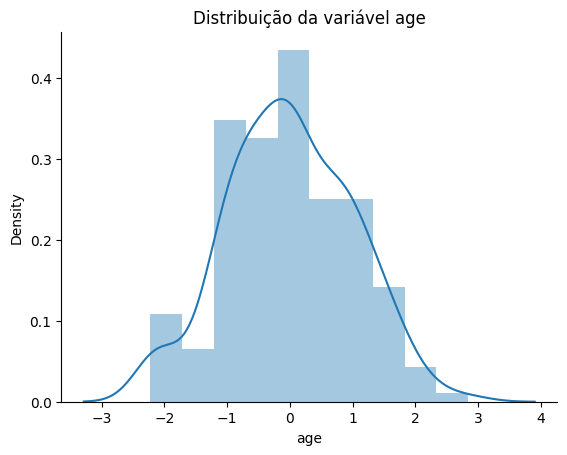

In [65]:
sns.distplot(df_titanic_ss['age'])
plt.title("Distribuição da variável age")
sns.despine()

In [66]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_titanic_ss['age'].skew()}")
print(f"Kurtosis: {df_titanic_ss['age'].kurt()}")

Skewness: 0.01841894050949496
Kurtosis: -0.2309427735598728


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

___
## **CBLOF - Cluster-based Local Outlier Factor**

In [67]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True


In [68]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = MinMaxScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [69]:
X1 = df_titanic_ss['age'].values.reshape(-1, 1)
X2 = df_titanic_ss['fare'].values.reshape(-1, 1)
X = np.concatenate((X1,X2), axis = 1)

OUTLIERS: 2 INLIERS: 180


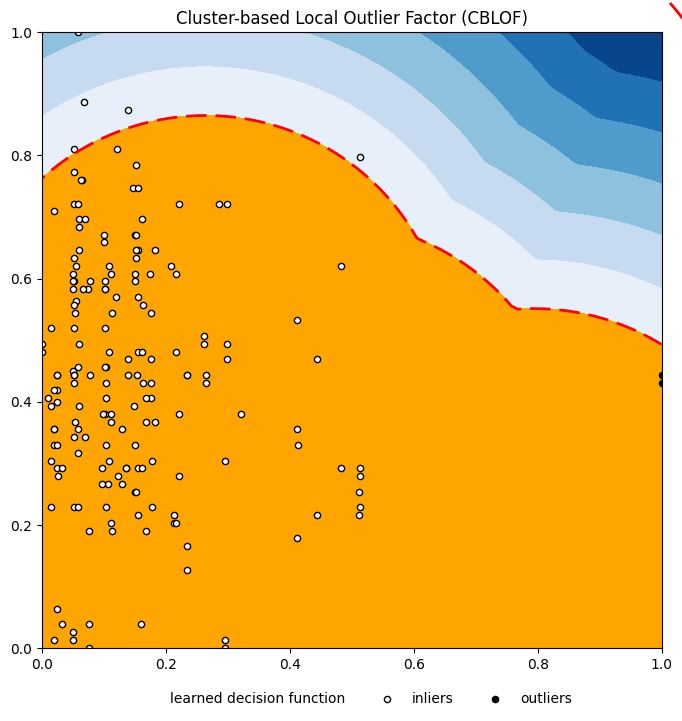

In [70]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

clf = CBLOF(contamination = outliers_fraction, check_estimator = False, random_state = 0)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize = (8, 8))

df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)

outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)

# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)

# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)

# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')

# Região Azul onde threshold < Anomaly Score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()], colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c = 'white', s = 20, edgecolor = 'k')

c = plt.scatter(outliers_fare, outliers_age, c = 'black', s = 20, edgecolor = 'k')

plt.axis('tight')
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop = matplotlib.font_manager.FontProperties(size = 10), loc = 'upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

In [71]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


### Dados originais (sem a transformação MinMaxScaler())
* Qual a idade e os valores pagos pelos Outliers?

In [72]:
df_titanic[['age', 'fare']].loc[679]

,679
age,36.000
fare,512.329


In [73]:
df_titanic[['age', 'fare']].loc[737]

,737
age,35.000
fare,512.329


### Questões interessantes: Age vs Fare
* Qual a idade e valor médio pago pelos passageiros que não sobreviveram?

In [74]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['survived', 'sex']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age   fare
                  mean   mean
survived sex                 
0        female 28.000 61.000
         male   43.000 65.000
1        female 33.000 91.000
         male   33.000 75.000

In [75]:
df_titanic['age_cat'] = pd.cut(df_titanic['age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_cat
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False,"(30, 40]"
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False,"(30, 40]"
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True,"(50, 60]"
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False,"(0, 10]"
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True,"(50, 60]"


<Axes: xlabel='age_cat', ylabel='fare'>

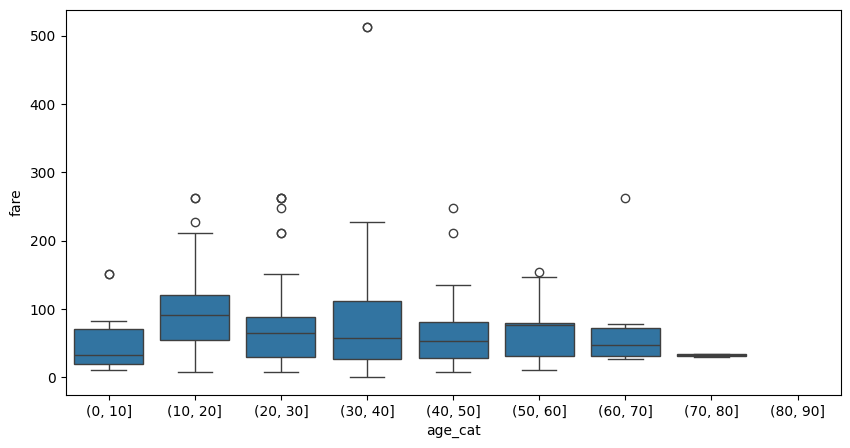

In [76]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'age_cat', y = 'fare', data = df_titanic)

In [77]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['survived', 'sex', 'age_cat']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age    fare
                           mean    mean
survived sex    age_cat                
0        female (0, 10]   2.000  81.000
                (10, 20]    NaN     NaN
                (20, 30] 27.000  81.000
                (30, 40]    NaN     NaN
                (40, 50] 50.000  29.000
                (50, 60] 57.000  10.000
                (60, 70]    NaN     NaN
                (70, 80]    NaN     NaN
                (80, 90]    NaN     NaN
         male   (0, 10]     NaN     NaN
                (10, 20] 19.000 108.000
                (20, 30] 26.000  93.000
                (30, 40] 36.000  42.000
                (40, 50] 46.000  57.000
                (50, 60] 55.000  59.000
                (60, 70] 64.000  74.000
                (70, 80] 71.000  35.000
                (80, 90]    NaN     NaN
1        female (0, 10]   4.000  28.000
                (10, 20] 17.000 108.000
                (20, 30] 25.000  89.000
                (30, 40] 36.000  93.000
                (40, 50] 46.000  90.000
                (50, 60] 55.000  86.000
                (60, 70] 63.000  78.000
                (70, 80]    NaN     NaN
                (80, 90]    NaN     NaN
         male   (0, 10]   3.000  56.000
                (10, 20] 14.000 115.000
                (20, 30] 26.000  54.000
                (30, 40] 35.000 116.000
                (40, 50] 47.000  54.000
                (50, 60] 55.000  43.000
                (60, 70]    NaN     NaN
                (70, 80] 80.000  30.000
                (80, 90]    NaN     NaN

___
## **HBOS - Histogram-based Outlier Detection**

OUTLIERS: 2 INLIERS: 180


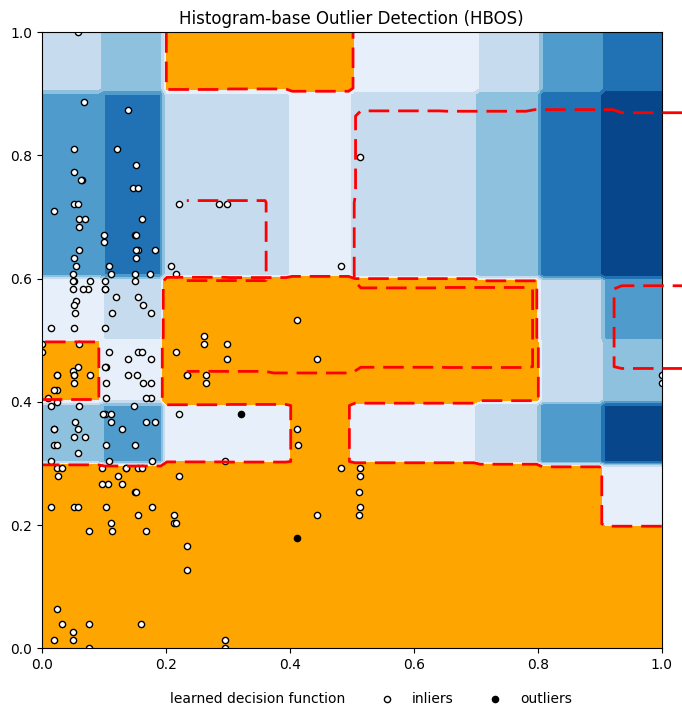

In [78]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination = outliers_fraction)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))

# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1, 1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1, 1)

outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1, 1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1, 1)

print('OUTLIERS:', n_outliers, 'INLIERS:', n_inliers)

# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)

# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)

# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')

# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels = [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')

c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')

plt.axis('tight')

plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc ='upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [79]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
318,1,1,female,0.380,0,2,0.322,S,First,woman,False,C,Southampton,yes,False,1
689,1,1,female,0.178,0,1,0.413,S,First,child,False,B,Southampton,yes,False,1


In [80]:
# Zoom na linha 689
df_titanic[['age', 'fare', 'survived']].loc[689]

,689
age,15.000
fare,211.338
survived,1.000


In [81]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['sex', 'survived']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age   fare
                  mean   mean
sex    survived              
female 0        28.000 61.000
       1        33.000 91.000
male   0        43.000 65.000
       1        33.000 75.000

In [82]:
# Zoom na linha 318
df_titanic[['age', 'fare', 'survived']].loc[318]

,318
age,31.000
fare,164.867
survived,1.000


___
## **Isolation Forest**

OUTLIERS:  2 INLIERS:  180


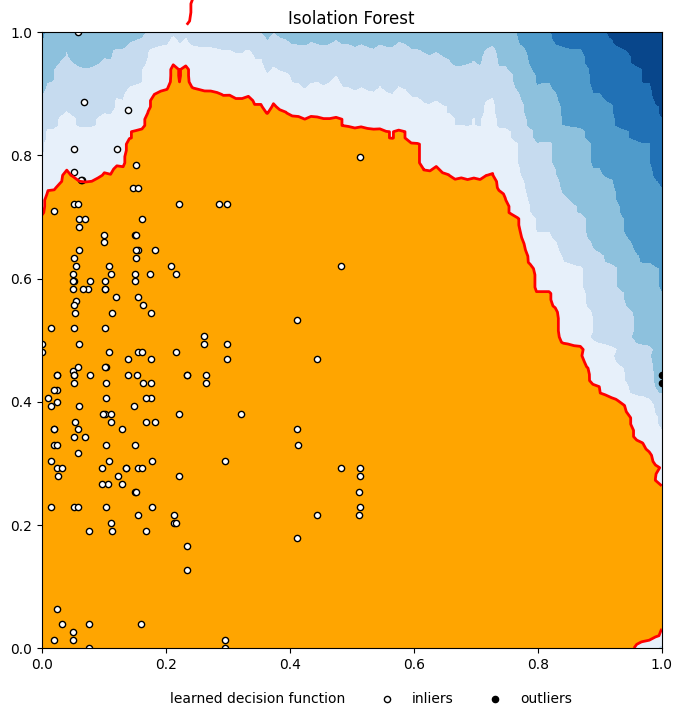

In [83]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination = outliers_fraction,random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)

# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS: ', n_outliers,'INLIERS: ', n_inliers)

# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')

# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')

c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')

plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol=5)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

São os mesmos pontos/observações apontadas pelo CBLOF.

___
## **KNN (K-Nearest Neighbors)**

OUTLIERS:  2 INLIERS:  180


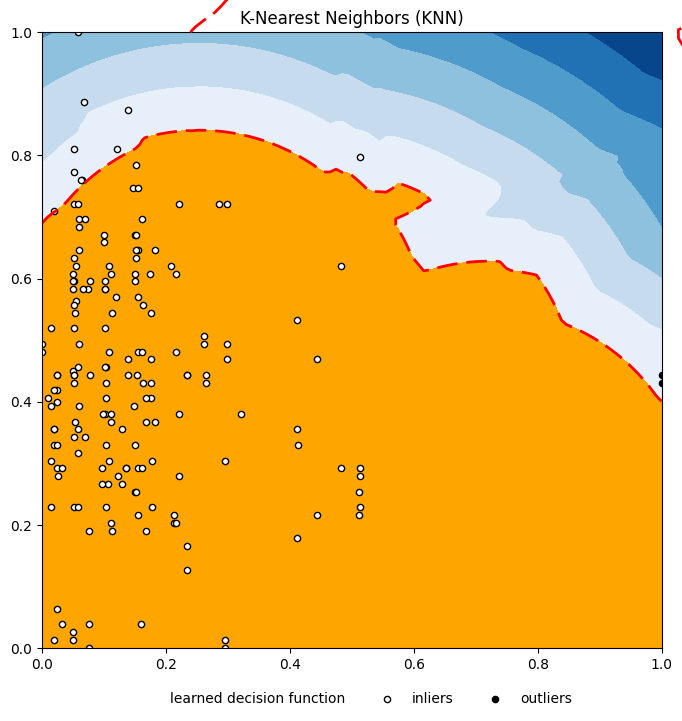

In [84]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination = outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)

outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS: ',n_outliers, 'INLIERS: ', n_inliers)

# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')

# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')

c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')

plt.axis('tight')

plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

São os mesmos pontos/observações apontadas pelo CBLOF.

___
# **Exercícios**
Para cada um dos dataframes a seguir, faça uma análise de outlier utilizando uma das técnicas apresentadas e explique seus resultados.

## Exercício 1 - Predict Breast Cancer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

df_cancer = pd.DataFrame(np.c_[X, y], columns= np.append(cancer['feature_names'], ['target']))
df_cancer['target'] = df_cancer['target'].map({0: 'malign', 1: 'benign'})
df_cancer.head()

## Exercício 2 - California Housing Price

In [ ]:
import pandas as pd
import numpy as np
#Instead of using load_boston, fetch_california_housing is used here
from sklearn.datasets import fetch_california_housing

# Load the California housing dataset
housing = fetch_california_housing()
X = housing['data']
y = housing['target']

# Create a Pandas DataFrame
df_boston = pd.DataFrame(np.c_[X, y], columns=np.append(housing['feature_names'], ['target']))
df_boston.head()

## Exercício 3 - Iris
* [Aqui](https://en.wikipedia.org/wiki/Iris_flower_data_set) você obterá mais informações sobre o dataframe iris.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X= iris['data']
y= iris['target']

df_iris = pd.DataFrame(np.c_[X, y], columns = np.append(iris['feature_names'], ['target']))
df_iris['target'] = df_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_iris.head()

## Exercícios 4 - Diabetes

In [ ]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes['data']
y = diabetes['target']

df_diabetes = pd.DataFrame(np.c_[X, y], columns = np.append(diabetes['feature_names'], ['target']))
df_diabetes.head()

# Exercícios 5
- Esses exercícios permitirão que os alunos explorem diferentes métodos de detecção de anomalias e compreendam os conceitos de curtose, assimetria, e métodos baseados em clusters e densidade local para identificar outliers em dados.

In [90]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np


def display_dataframe_to_user(name, dataframe):
    """Displays the dataframe to the user with a given name."""
    print(f"\n{name}:")
    print(dataframe.head())
    # You can add further dataframe analysis, exploration, or visualization here if needed.


# Generate a synthetic dataset with 5,000 rows and 10 numerical columns
n_rows = 5000
n_columns = 10

# Create clusters of data to simulate a realistic dataset with potential outliers
X, _ = make_blobs(
    n_samples=n_rows,
    n_features=n_columns,
    centers=5,
    cluster_std=[1.0, 2.5, 1.5, 3.0, 0.5],
    random_state=42,
)

# Convert to DataFrame
df_outlier_detection = pd.DataFrame(
    X, columns=[f"Feature_{i+1}" for i in range(n_columns)]
)

# Introduce a few extreme outliers manually to ensure variety in the dataset
np.random.seed(42)
outlier_indices = np.random.choice(
    df_outlier_detection.index, size=50, replace=False
)
df_outlier_detection.loc[outlier_indices] = (
    df_outlier_detection.loc[outlier_indices]
    * np.random.uniform(3, 10, size=(50, n_columns))
)

# Display the generated dataset to the user
display_dataframe_to_user(
    name="Synthetic Dataset for Outlier Detection Practice",
    dataframe=df_outlier_detection,
)


Synthetic Dataset for Outlier Detection Practice:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0     -6.506      8.556      8.685      1.740     -6.101     -7.914   
1     -1.538      1.683     -8.293     11.830      8.388      3.154   
2      1.654      1.490     -8.451     10.769      3.249      3.686   
3     -1.913      8.380      4.404      2.717     -6.458     -6.613   
4     -7.434      0.311     -9.749      8.820     -4.822      3.670   

   Feature_7  Feature_8  Feature_9  Feature_10  
0     -3.484      1.112     -2.672      -3.071  
1     -5.352     -7.662      2.304       4.558  
2     -2.351    -12.890      5.333      -3.372  
3     -9.177      7.694      1.899       4.619  
4     -3.611      0.463      1.051      -5.967  


1. Cálculo de Estatísticas Descritivas
- Calcule as estatísticas descritivas (média, mediana, desvio padrão, mínimo e máximo) para cada coluna do dataset. Use essas informações para entender a distribuição dos dados e identificar possíveis valores extremos.

2. Análise de Curtose e Assimetria (Kurtosis e Skewness)
- Calcule a kurtosis e skewness para cada coluna. Analise os resultados e identifique quais colunas têm maior assimetria ou curtose, indicando a presença de outliers ou distribuições não normais.

3. Identificação de Outliers usando o Método IQR
- Utilize o método do intervalo interquartílico (IQR) para identificar outliers em uma ou mais colunas. Marque como outliers os valores que estão fora de 1,5 vezes o IQR acima do terceiro quartil ou abaixo do primeiro quartil.

4. Detecção de Outliers com Z-Score
- Calcule o Z-Score para cada valor de uma coluna selecionada (por exemplo, `Feature_1`). Considere como outliers os valores com Z-Score acima de 3 ou abaixo de -3. Quantos outliers foram detectados?

5. Cluster-Based Local Outlier Factor (LOF)
- Aplique o algoritmo LOF para detectar outliers com base na densidade local dos dados. Use Scikit-Learn para implementar o LOF e identifique quais pontos são considerados outliers. Interprete os resultados observando quais clusters contêm mais outliers.

6. Histogram-Based Outlier Detection (HBOS)
- Utilize a técnica HBOS para detectar outliers em uma coluna. Crie histogramas para as colunas e observe quais valores são pouco frequentes, indicando possíveis anomalias.

7. Detecção de Anomalias com Isolation Forest
- Aplique o algoritmo Isolation Forest para identificar anomalias em todo o dataset. Identifique os registros classificados como outliers e analise se estão concentrados em algumas colunas ou distribuídos pelo dataset.

8. Detecção de Outliers com K-Nearest Neighbors (KNN)
- Aplique o KNN para detectar outliers com base na distância entre os pontos vizinhos mais próximos. Analise quais registros têm as maiores distâncias para os pontos vizinhos e verifique se são outliers.

9. Visualização de Outliers com Boxplot
- Crie boxplots para todas as colunas numéricas do dataset e visualize onde os outliers estão localizados. Analise em quais colunas há maior quantidade de outliers.

10. Comparação entre Métodos de Detecção de Outliers
- Compare os diferentes métodos de detecção de outliers aplicados (IQR, Z-Score, LOF, HBOS, Isolation Forest e KNN) para uma coluna específica, como `Feature_1`. Discuta as diferenças entre os métodos e qual seria o mais adequado para diferentes contextos.